# Latent diffusion models on HR images 

<a name="introduction"></a>

1. Introduction

Latent Diffusion Models (LDMs) are a class of deep generative models that combine the strengths of autoencoders and diffusion models. They perform the diffusion process in a lower-dimensional latent space, which makes them computationally efficient while generating high-quality data.

This training will be performed with the Galaxy Zoo Dataset :

The Galaxy Zoo Dataset is a citizen science project initiated as part of the Zooniverse platform, designed to involve the public in the morphological classification of galaxies. It consists of images sourced from large-scale sky surveys like the Sloan Digital Sky Survey (SDSS), Hubble Space Telescope, and others.

This notebook is made to train the autoencoder and then the diffusion model from the latent space. 


<a name="setup"></a>
2. Setup



In [1]:
import os, sys
import datetime
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import PIL
from tqdm import tqdm

# Scikit-learn
from sklearn.manifold import TSNE

# PyTorch
import torch
from torchvision.transforms import (Compose, ToTensor,
                                    Lambda, Resize, CenterCrop,
                                    RandomHorizontalFlip,
                                    RandomRotation, Normalize)
from packaging import version

torch_version = version.parse(torch.__version__)

if version.parse(torch.__version__) >= version.parse("2.5.0"):
    from torch.amp import autocast, GradScaler
else:
    from torch.cuda.amp import autocast, GradScaler

from torch.utils.data import random_split
from torch.utils.data._utils.collate import default_collate
from torch.utils.data import DataLoader
from pytorch_msssim import ssim
import torch.nn.functional as F

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Custom Libraries
from libGalaxyZooDataset import *
from libDDPM import *
from libGPU_torch_utils import *
#from libAutoEncoder import *

In [2]:
# Custom loss function combining MSE and SSIM
# SSMI = Structural Similarity Index Measure 
# (https://en.wikipedia.org/wiki/Structural_similarity)

def loss_with_ssmi(reconstructed, original):
    mse_loss = F.mse_loss(reconstructed, original)
    ssim_loss = 1 - ssim(reconstructed, original,
                         data_range=1, size_average=True)  # SSIM loss (inverted)
    return mse_loss + 0.1 * ssim_loss  # Weight SSIM loss by a factor, adjust as needed

def version_aware_autocast(device):
    """
    Create an autocast context manager based on the PyTorch version.
    Depending on the version, the `device_type` argument may or 
    may not be supported.
    
    Args:
        device (str): Device to use (cpu or cuda).

    Returns:
        autocast: Context manager for mixed precision training.
    """
    if torch_version >= version.parse("2.5.0"):
        return autocast(device_type="cuda" if device == "cuda" else "cpu")
    else:
        return autocast()

def visualize_latent_space(latent_vectors, labels, epoch, output_dir, strdate):
    """
    Visualizes the latent space using t-SNE.

    Args:
        latent_vectors (np.array): Latent vectors from the encoder.
        labels (list): Corresponding labels for each vector.
        epoch (int): Current epoch number (for saving).
        output_dir (str): Directory to save the plot.
        strdate (str): Timestamp string for filenames.
    """
    
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vectors = tsne.fit_transform(latent_vectors)

    df = pd.DataFrame({
        'x': reduced_vectors[:, 0],
        'y': reduced_vectors[:, 1],
        'label': labels
    })

    # Plot using seaborn
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='x', y='y', hue='label', palette='viridis', data=df, alpha=0.8)
    plt.title(f'Latent Space Visualization at Epoch {epoch}')
    plt.legend(title='Labels', loc='best')
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(output_dir, f"{strdate}_latent_space_epoch_{epoch:03}.png"))
    plt.close()


3. Read the parameters from the config file

All the parameters are save into a single file : 'param_GZ2.json'


In [3]:
# Define the path to the parameters file
parameters_file = 'param_GZ2.json'
SEED = 42


#if __name__ == '__main__':

print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

if os.path.exists(parameters_file):
# Load the parameters from the JSON file
    with open(parameters_file, 'r') as json_file:
        parameters = json.load(json_file)

    # Now you can access the parameters using dictionary-style access
    no_train = parameters['no_train']
    verbose = parameters['verbose']
    test_model = parameters['test_model']
    batch_size = parameters['batch_size']
    latent_dim = parameters['latent_dim']
    n_epochs = parameters['n_epochs']
    lr = parameters['lr']
    n_steps = parameters['n_steps']
    min_beta = parameters['min_beta']
    max_beta = parameters['max_beta']
    nb_gal4training = parameters['nb_gal4training']
    nb_gal2plot = parameters['nb_gal2plot']
    plot_subset = parameters['plot_subset']
    output_model = parameters['output_model']
    ref_column_file = parameters['ref_column_file']
    mapping_file = parameters['mapping_file']
    DATALOCATION_DIR = parameters['DATALOCATION_DIR']
    DDPM_dir = parameters['DDPM_dir']
    output_dir = parameters['output_dir']
    plot_reconstruction = parameters['plot_reconstruction']        
    save_freq = parameters['save_freq']
    val_freq = parameters['val_freq'] 

    # Carbon followup
    carbon_estimation = parameters['carbon_estimation']
    carbon_log_dir = parameters['carbon_log_dir']
    carbon_log_file = parameters['carbon_log_file']
    training_log_file = parameters['training_log_file']

else:
    print(f"File {parameters_file} does not exist")
    sys.exit(1)

CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA RTX 3000 Ada Generation Laptop GPU


4. Data preparation

Working with the Galaxie Zoo 2 Dataset

In [4]:
np.random.seed(SEED)
torch.manual_seed(SEED)

mydevice = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = setup_device(mydevice)


if not os.path.exists('tensorboard_logs'):
    os.makedirs('tensorboard_logs')
tensorboard_log_dir = os.path.join(DDPM_dir, 'tensorboard_logs_LDM')
writer = SummaryWriter(log_dir=tensorboard_log_dir)

### Load the data ###
print("\n"+"-"*50)
print("Read the file with all the galaxies...")
print("-"*50+"\n")

# Check if the file exists and is not empty
if not os.path.exists(os.path.join(DATALOCATION_DIR, ref_column_file)):
    print(f"File {ref_column_file} does not exist in {DATALOCATION_DIR}")
    sys.exit(1)

if os.path.getsize(os.path.join(DATALOCATION_DIR, ref_column_file)) <= 0:
    print(f"File {ref_column_file} is empty")
    sys.exit(1)

df_galaxy_zoo_header = pd.read_csv(os.path.join(DATALOCATION_DIR,
                                                ref_column_file), delimiter=',',
                                                header=0)

Device 0 name: NVIDIA RTX 3000 Ada Generation Laptop GPU
Valid GPU references: ['cuda:0']
GPU cuda:0 may be currently in use...

--------------------------------------------------
Read the file with all the galaxies...
--------------------------------------------------



4.1 Prepare a subset of data

To speed up the training, we are only using a subset of data. 
One can select the data according to the morphology of the galaxies.

Then, this cell prepare the Dataloaders, one for the train dataset and one for the validation dataset.

We also define a transformation to increase the dataset size and improve the quality of the training.

Selection of spiral galaxies from the dataset:
Number of spiral galaxies in the dataset: 141430
Number of spiral galaxies for training: 141000
Show the first batch of images...


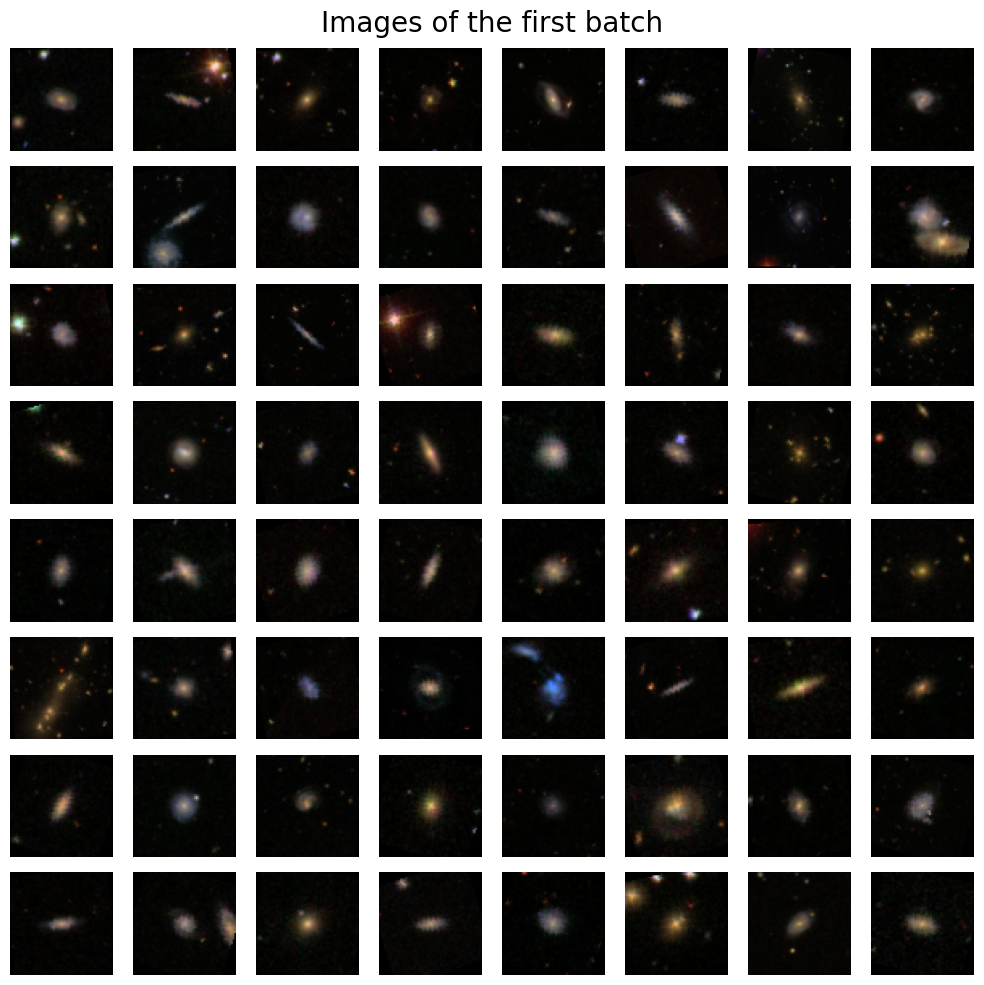

In [5]:
morpho = 'S'
morpho_gal = {'S': 'spiral', 'E': 'elliptical', 'A': 'erregular'}

# Display the spiral galaxies (gz2_class starting with 'S')
print("Selection of spiral galaxies from the dataset:")
df_sub_morpho = df_galaxy_zoo_header[df_galaxy_zoo_header['gz2_class'].str.startswith(morpho)]

# Load the mapping file
df_mapping = pd.read_csv(os.path.join(DATALOCATION_DIR, mapping_file),
                            delimiter=',',
                            header=0)

# Match where dr7objid in df_spiral = objid in df_mapping to add asset_id to the df_spiral
df_sub_morpho = pd.merge(df_sub_morpho, df_mapping, left_on='dr7objid', right_on='objid')

print(f"Number of {morpho_gal[morpho]} galaxies in the dataset: {df_sub_morpho.shape[0]}")
if nb_gal4training < 0 or nb_gal4training > df_sub_morpho.shape[0]:
    nb_gal2training = df_sub_morpho.shape[0]
else:   
    nb_gal4training = min(nb_gal4training, df_sub_morpho.shape[0])

print(f"Number of {morpho_gal[morpho]} galaxies for training: {nb_gal4training}")
# Create a subset of galaxies to plot if needed
df_sub_morpho_subset = df_sub_morpho.sample(n=nb_gal4training, random_state=SEED)

# Exit if the subset is empty
if df_sub_morpho_subset.empty:
    print("The subset of galaxies is empty")
    sys.exit(1)

# ---------------------------------------------------------------------------
#
# PREPARE DATA LOADERS
#
# ---------------------------------------------------------------------------

transform = Compose([
    Resize((64, 64)),
    #CenterCrop(40),
    RandomHorizontalFlip(),
    RandomRotation(20),
    ToTensor(),
    Lambda(lambda x: x.float())
])

transform_tanh = Compose([
    Resize((64, 64)),
    #CenterCrop(40),
    RandomHorizontalFlip(),
    RandomRotation(20),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5])
])

# Define the dataset and the dataloader
dataset = GalaxyZooDataset(df_sub_morpho_subset, DATALOCATION_DIR,
                        transform=transform)

dataset_size = len(dataset)
validation_split = 0.2  # 20% for validation
validation_size = int(validation_split * dataset_size)
training_size = dataset_size - validation_size

train_dataset, val_dataset = random_split(dataset,
                                          [training_size, validation_size])

# Custom collate function to handle the variable image sizes or empty tensors
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                        shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, collate_fn=custom_collate)

# Free up memory
del df_galaxy_zoo_header, df_sub_morpho, df_mapping, df_sub_morpho_subset
del dataset
del train_dataset
del val_dataset

# ---------------------------------------------------------------------------
if verbose:
    print("Show the first batch of images...")
    show_first_batch(train_loader, save2file=True,
                        filename='output/first_batch_GZ2.png')
    plt.show()

### AUTOENCODER - Training phase

The purpose of the autoencoder in the Latent Diffusion Model (LDM) is to learn a compact latent representation of the input images. This latent representation will then serve as the space where the diffusion process operates, significantly reducing computational complexity.



In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=128):
        """
        Encoder: Extracts latent features from input images.
        Args:
            latent_dim (int): Dimensionality of the latent space.
        """
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, latent_dim),
        )
        self.latent_norm = nn.Tanh()
        
    def forward(self, x):
        z = self.encoder(x)
        return self.latent_norm(z)

class Decoder(nn.Module):
    def __init__(self, latent_dim=128):
        """
        Decoder: Reconstructs images from latent features.
        Args:
            latent_dim (int): Dimensionality of the latent space.
        """
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512 * 4 * 4),  # Match encoder's downsampled size
            nn.LeakyReLU(0.1),

            nn.Unflatten(1, (512, 4, 4)),  

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output values between [0, 1]
        )

    def forward(self, x):
        return self.decoder(x)
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
autoencoder_training = False

if autoencoder_training:

    # bypass n_epochs
    n_epochs = 10

    autoencoder = Autoencoder(latent_dim=latent_dim).to(device)

    optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=1e-4) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                        patience=5, factor=0.5)


    # The following code block is used to handle mixed precision training
    # It could be put into a function to avoid code duplication TODO
    if torch_version < version.parse("2.5.0"):
        scaler = torch.amp.GradScaler(init_scale=65536.0, growth_interval=2000)
    else:
        scaler = GradScaler()

    num_epochs = n_epochs
    best_val_loss = float('inf')
    patience = 10
    trigger_times = 0

    # For plotting
    train_losses = []
    val_losses = []

    # To visualize latent space
    latent_vectors = []
    labels = []
    reconstruction_errors = []

    datenow = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    strdate = f"{datenow}_autoencoder_training"




    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0
        step_bar = tqdm(train_loader, leave=False,
                            desc=f"Epoch {epoch + 1}/{num_epochs}",
                            colour="#005500")
        for _, batch in enumerate(step_bar):
            if batch is None:  # Skip batches with missing files
                continue

            x0 = batch[0].to(device)   # Input images
            batch_labels = batch[2]
            #with autocast(device_type="cuda" if device == "cuda" else "cpu"):
            with version_aware_autocast(device):
                encoded = autoencoder.encoder(x0)
                decoded = autoencoder.decoder(encoded)
                loss = loss_with_ssmi(decoded, x0)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

        # Estimate validation loss every `val_freq` epochs
        if (epoch + 1) % val_freq != 0: 
            autoencoder.eval()
            val_loss = 0.0

            latent_vectors_list = []
            labels_list = []

            with torch.no_grad():
                for _, batch in enumerate(val_loader):
                    if batch is None:
                        continue

                    x0 = batch[0].to(device)
                    batch_labels = batch[2]

                #with autocast(device_type="cuda" if device == "cuda" else "cpu"):
                with version_aware_autocast(device):
                    encoded = autoencoder.encoder(x0)
                    decoded = autoencoder.decoder(encoded)
                    loss = loss_with_ssmi(decoded, x0)

                    val_loss += loss.item()

                    # Compute reconstruction error per sample
                    errors = torch.mean((x0 - decoded) ** 2, dim=[1, 2, 3])  # MSE per sample
                    reconstruction_errors.extend(errors.detach().cpu().numpy())


                    # Collect latent vectors and labels
                    latent_vectors_list.append(encoded.detach().cpu().numpy())
                    labels_list.extend(batch_labels)

            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

        # Plot reconstruction error distribution
        if plot_reconstruction:
            
            plt.figure(figsize=(8, 6))
            plt.hist(reconstruction_errors, bins=50, color='skyblue', edgecolor='black')
            plt.title(f'Histogram of Reconstruction Errors at Epoch {epoch}')
            plt.xlabel(f'Reconstruction Error at Epoch {epoch}')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.savefig(os.path.join(output_dir,f'{strdate}_reconstruction_errors_{epoch:03}.png'))
            #plt.show()

            # Visualize original and reconstructed images
            autoencoder.eval()
            with torch.no_grad():
                sample_batch = next(iter(val_loader))[0].to(device)
                with autocast(device_type="cuda" if device == "cuda" else "cpu"):
                    reconstructed_batch = autoencoder(sample_batch)

            sample_batch = sample_batch.cpu()
            reconstructed_batch = reconstructed_batch.cpu()

            n = 6  # Number of images to display
            plt.figure(figsize=(12, 4))
            for i in range(n):
                # Original images
                ax = plt.subplot(2, n, i + 1)
                plt.imshow(np.transpose(sample_batch[i].numpy(), (1, 2, 0)))
                plt.title("Original")
                plt.axis('off')

                # Reconstructed images
                ax = plt.subplot(2, n, i + 1 + n)
                plt.imshow(np.transpose(reconstructed_batch[i].numpy(), (1, 2, 0)))
                plt.title("Reconstructed")
                plt.suptitle(f"Original and Reconstructed Images at Epoch {epoch}")
                plt.axis('off')
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir,
                                    f"{strdate}_reconstructed_images_{epoch:03}.png"))
            #plt.show()

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        scheduler.step(avg_val_loss)

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(autoencoder.state_dict(),
                        os.path.join(output_dir,
                                    f"{strdate}_best_autoencoder.pth"))
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

        # Save the model every save_freq epochs
        if (epoch + 1) % save_freq == 0:
            torch.save(autoencoder.state_dict(),
                        os.path.join(output_dir,
                                    f"{strdate}_autoencoder_epoch_{epoch+1}.pth"))
            torch.cuda.empty_cache()

        # Concatenate all latent vectors
        latent_vectors = np.concatenate(latent_vectors_list, axis=0)
        labels = np.array(labels_list)
        
        subset_size = 1000
        if len(latent_vectors) > subset_size:
            indices = np.random.choice(len(latent_vectors), size=subset_size,
                                    replace=False)
            latent_vectors_subset = latent_vectors[indices]
            labels_subset = labels[indices]
        else:
            latent_vectors_subset = latent_vectors
            labels_subset = labels

        # Visualize latent space
        visualize_latent_space(latent_vectors_subset, labels_subset, epoch, 
                            output_dir, strdate)

 #### Visualisation of the LOSS for Autoencoder training

In [8]:
if autoencoder_training:

    # After training
    print("Training complete! Plotting training and validation loss...")
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.yscale('log')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir,
                                f"{strdate}_training_validation_loss.png"))
    plt.show()
    #plt.close()

## Latent Diffusion Model

### Implementing the Diffusion Process

At that stage, the autoencoder is trained. 

We now reload the best latent model which will be used as input of the diffusion model


In [9]:

class LatentDiffusionModel(nn.Module):
    """
    Latent Diffusion Model for image generation

    Args:
        network (nn.Module): Neural network for predicting noise
        n_steps (int): Number of steps in the diffusion process
        min_beta (float): Minimum value of beta
        max_beta (float): Maximum value of beta
        device (str): Device to run the model on
        latent_dim (int): Dimension of the latent space
        
    """

    def __init__(self, network, n_steps=1000, min_beta=1e-4, max_beta=0.02, 
                 device=None, latent_dim=128):
        super(LatentDiffusionModel, self).__init__()
        self.network = network.to(device)
        self.n_steps = n_steps
        self.latent_dim = latent_dim
        self.device = device

        # Diffusion hyper param'
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) \
                                        + 1e-6 for i in range(len(self.alphas))]).to(device)

    def q_t(self, z_0, t, eps=None):
        """
        Compute the diffusion process at time t 
        on the latent space : 
        q(z_t| z_0) = N(z_t | mu_t, sigma_t) with 

        beta_i = betas[i]
        alpha_bar_t = prod_{i=1}^{t} (1 - beta_i)

        mu_t = sqrt(1 - alpha_bar_t) * z_0
        sigma_t = sqrt(alpha_bar_t) * I

        z_t = mu_t + sigma_t * eps

        Args:
            z_0 (torch.Tensor): Initial latent vector
            t (int): Time step
            eps (torch.Tensor): Noise tensor
        """
        # alpha_bar_t: [batch_size] after indexing
        alpha_bar_t = self.alpha_bars[t]  # [batch_size]
        alpha_bar_t = alpha_bar_t.unsqueeze(1)  # [batch_size, 1]
        # Broadcast alpha_bar_t to match z_0: [batch_size, latent_dim]
        # Since latent_dim is the same for all samples, we can expand:
        alpha_bar_t = alpha_bar_t.expand(-1, self.latent_dim)  # [batch_size, latent_dim]

        z_t = (alpha_bar_t.sqrt() * z_0) + ((1 - alpha_bar_t).sqrt() * eps)
        # z_t: [batch_size, latent_dim]
        return z_t

    def predict_eps(self, z_t, t):
        """
        Predict the noise added at timestep t

        """
        return self.network(z_t, t)

    def compute_loss(self, z_0, t):
        """
        Loss calculation for the diffusion model
        
        Formula:
        L = ||eps_theta - eps||^2   with eps ~ N(0, I)

        Args:
            z_0 (torch.Tensor): Initial latent vector
            t (int): Time step
        """
        eps = torch.randn_like(z_0)        # [batch_size, latent_dim]
        z_t = self.q_t(z_0, t, eps)        # [batch_size, latent_dim]
        eps_theta = self.predict_eps(z_t, t)  # [batch_size, latent_dim]
        
        loss_fn = nn.MSELoss()
        return loss_fn(eps_theta, eps)
    
    @torch.no_grad()
    def p_sample(self, z_t, t):
        """
        Reverse diffusion process
        p(z_0 | z_t) = N(z_0 | mu_t, sigma_t) with

        beta_i = betas[i]
        alpha_bar_t = prod_{i=1}^{t} (1 - beta_i)

        Args:
            z_t (torch.Tensor): Latent vector at time t
            t (int): Time step

        """

        # Extract scalars per batch element
        beta_t = self.betas[t]          # [batch_size]
        alpha_t = self.alphas[t]        # [batch_size]
        alpha_bar_t = self.alpha_bars[t]# [batch_size]

        # alpha_bar_prev (for t>0), else 1.0
        alpha_bar_prev = torch.where(
            t > 0,
            self.alpha_bars[(t-1).clamp(min=0)],
            torch.ones_like(alpha_bar_t)
        )  # [batch_size]

        # Expand all to [batch_size, latent_dim]
        beta_t = beta_t.unsqueeze(1).expand(-1, self.latent_dim)
        alpha_t = alpha_t.unsqueeze(1).expand(-1, self.latent_dim)
        alpha_bar_t = alpha_bar_t.unsqueeze(1).expand(-1, self.latent_dim)
        alpha_bar_prev = alpha_bar_prev.unsqueeze(1).expand(-1, self.latent_dim)

        eps_theta = self.predict_eps(z_t, t)  # [batch_size, latent_dim]

        noise = torch.randn_like(z_t)         # [batch_size, latent_dim]
        sigma_t = ((1 - alpha_bar_prev) / (1 - alpha_bar_t) * beta_t).sqrt() # [batch_size, latent_dim]

        z_prev = (z_t - (1 - alpha_t).sqrt() * eps_theta) / alpha_t.sqrt()

        # Add noise if t>0
        mask = (t > 0).unsqueeze(1).expand(-1, self.latent_dim)  # [batch_size, latent_dim]
        z_prev = z_prev + torch.where(mask, sigma_t * noise, torch.zeros_like(z_t))
        return z_prev
    

    @torch.no_grad()
    def generate_sample(self, num_samples):
        """
        Generate samples from the model
    
        """
        z_t = torch.randn(num_samples, self.latent_dim).to(self.device)

        for t in reversed(range(self.n_steps)):
            t_tensor = torch.full((num_samples, 1), t,
                                  dtype=torch.long).to(self.device)
            z_t = self.p_sample(z_t, t_tensor)

        return z_t
    
    @torch.no_grad()
    def decode_latent(self, z_0, decoder):
        """
        Decode the latent vector to an image

        Args:
            z_0 (torch.Tensor): Latent vector
            decoder (nn.Module): pre-trained decoder

        Returns:
            torch.Tensor: Decoded image
        """
        return decoder(z_0)

### Reusing the autoencoder 



In [10]:


n_epochs_diffusion = 10
learning_rate = 1e-4

best_ae_path = os.path.join(output_dir, "20241128_084322_autoencoder_training_best_autoencoder.pth")

# Chargement de l'autoencodeur pré-entraîné
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)
autoencoder.load_state_dict(torch.load(best_ae_path))
autoencoder.eval()  # Mode évaluation pour éviter toute modification des poids
print(f"Best autoencoder reloaded from file {best_ae_path}.")

class NoisePredictor(nn.Module):
    def __init__(self, latent_dim):
        super(NoisePredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

    def forward(self, z_t, t):
        # z_t is [batch_size, latent_dim]
        return self.net(z_t)

Best autoencoder reloaded from file output/20241128_084322_autoencoder_training_best_autoencoder.pth.


/tmp/ipykernel_18666/3663564585.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(best_ae_path))


## Training the diffusion model on the latent space

Instead of training the diffusion model on the images, the latent diffusion model is training the diffusion network on the latent space. 

The model used in the diffusion model is often a U-Net. But here, for the sake of this example, we are just using a FCN.


In [12]:
diffusion_model_training = True
if diffusion_model_training:

    noise_predictor = NoisePredictor(latent_dim=latent_dim).to(device)

    diffusion_model = LatentDiffusionModel(
        network=noise_predictor,
        n_steps=n_steps,
        min_beta=min_beta,
        max_beta=max_beta,
        latent_dim=latent_dim,
        device=device
    )

    optimizer_diffusion = torch.optim.Adam(diffusion_model.network.parameters(), lr=learning_rate)
    scheduler_diffusion = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_diffusion, mode='min',
                                                        patience=5, factor=0.5)

    if torch_version < version.parse("2.5.0"):
        scaler = torch.amp.GradScaler(init_scale=65536.0, growth_interval=2000)
    else:
        scaler = GradScaler()

    # Diffusion model training
    for epoch in range(n_epochs_diffusion):
        diffusion_model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs_diffusion}", leave=False)
        False
        for images in progress_bar:
            x0 = images[0].to(device)

            with torch.no_grad():  # L'autoencodeur n'est pas modifié
                z_0 = autoencoder.encoder(x0)


            t = torch.randint(0, n_steps, (z_0.size(0),), device=device)
            with version_aware_autocast(device):
                loss = diffusion_model.compute_loss(z_0, t)

            optimizer_diffusion.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer_diffusion)
            scaler.update()

            running_loss += loss.item() * z_0.size(0)
            progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        epoch_loss = running_loss / len(train_loader.dataset)
        tqdm.write(f"Epoch [{epoch+1}/{n_epochs_diffusion}], Training Loss: {epoch_loss:.4f}")
        progress_bar.set_postfix({"Train loss": f"{epoch_loss:.4f}"})

        scheduler_diffusion.step(epoch_loss)

        diffusion_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images in val_loader:
                x0 = images[0].to(device)
                z_0 = autoencoder.encoder(x0)
                t = torch.randint(0, n_steps, (z_0.size(0),), device=device)

                with autocast(device_type="cuda" if device == "cuda" else "cpu"):
                    loss = diffusion_model.compute_loss(z_0, t)
                val_loss += loss.item() * z_0.size(0)

        val_loss /= len(val_loader.dataset)
        tqdm.write(f"Epoch [{epoch+1}/{n_epochs_diffusion}], Validation Loss: {val_loss:.4f}")
        progress_bar.set_postfix({"Val loss": f"{val_loss:.4f}"})

        # Log the losses to TensorBoard
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        writer.add_scalar("Loss/val", val_loss, epoch)

        # Save the model every save_freq epochs
        if (epoch + 1) % 10 == 0:
            save_path = os.path.join(output_dir, f"diffusion_model_epoch_{epoch + 1}.pth")
            torch.save(diffusion_model.state_dict(), save_path)

    # Sauvegarde du modèle de diffusion
    torch.save(diffusion_model.state_dict(), os.path.join(output_dir, "diffusion_model.pth"))
    print("Modèle de diffusion sauvegardé sous 'diffusion_model.pth'.")


Epoch 1/10:   0%|          | 0/1763 [00:00<?, ?it/s]

Epoch [1/10], Training Loss: 0.7243
Epoch [1/10], Validation Loss: 0.5329


Epoch [2/10], Training Loss: 0.4636
Epoch [2/10], Validation Loss: 0.4114


Epoch [3/10], Training Loss: 0.3799
Epoch [3/10], Validation Loss: 0.3532


Epoch [4/10], Training Loss: 0.3336
Epoch [4/10], Validation Loss: 0.3141


Epoch [5/10], Training Loss: 0.2996
Epoch [5/10], Validation Loss: 0.2857


Epoch [6/10], Training Loss: 0.2731
Epoch [6/10], Validation Loss: 0.2613


Epoch [7/10], Training Loss: 0.2510
Epoch [7/10], Validation Loss: 0.2420


Epoch [8/10], Training Loss: 0.2351
Epoch [8/10], Validation Loss: 0.2279


Epoch [9/10], Training Loss: 0.2210
Epoch [9/10], Validation Loss: 0.2130


Epoch [10/10], Training Loss: 0.2091
Epoch [10/10], Validation Loss: 0.2044
Modèle de diffusion sauvegardé sous 'diffusion_model.pth'.


## Image generation 

/tmp/ipykernel_18666/2195225674.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion_model.load_state_dict(torch.load(os.path.join(output_dir, "diffusion_model_epo

Diffusion model loaded from file.
LatentDiffusionModel(
  (network): NoisePredictor(
    (net): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=512, bias=True)
    )
  )
)
Latent dimensions: 512
Initial z_t shape: torch.Size([16, 512])
t_tensor shape at step 999: torch.Size([16])
z_t shape at step 999: torch.Size([16, 512])
t_tensor shape at step 998: torch.Size([16])
z_t shape at step 998: torch.Size([16, 512])
t_tensor shape at step 997: torch.Size([16])
z_t shape at step 997: torch.Size([16, 512])
t_tensor shape at step 996: torch.Size([16])
z_t shape at step 996: torch.Size([16, 512])
t_tensor shape at step 995: torch.Size([16])
z_t shape at step 995: torch.Size([16, 512])
t_tensor shape at step 994: torch.Size([16])
z_t shape at step 994: torch.Size([16, 512])
t_tensor shape at step 993: torch.Size([16])
z_t

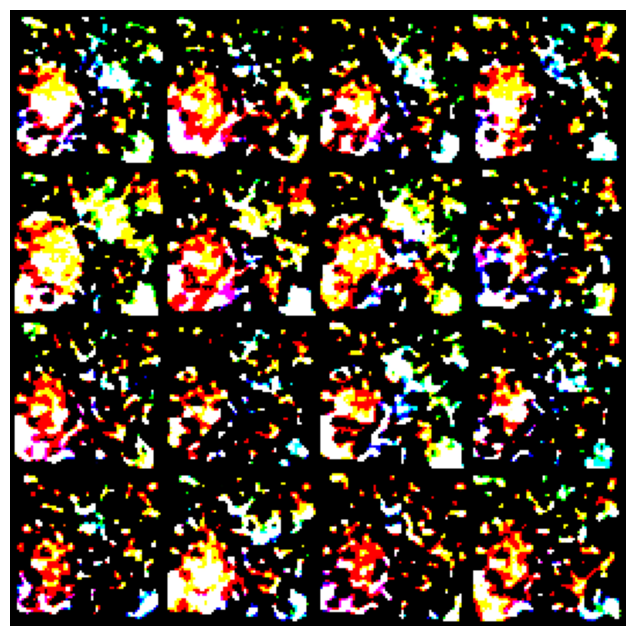

In [13]:
#from libLDM import LatentDiffusionModel

@torch.no_grad()
def generate_samples(diffusion_model, autoencoder, num_samples):
    """
    Generate samples using the trained diffusion model and autoencoder.
    
    Args:
        diffusion_model (LatentDiffusionModel): The trained diffusion model.
        autoencoder (Autoencoder): The trained autoencoder.
        num_samples (int): Number of samples to generate.
    
    Returns:
        torch.Tensor: Generated images.
    """
    # Initialize latent vectors z_t with the same spatial dimensions as the encoder output
    latent_shape = (num_samples, latent_dim, 16, 16)  # Adjust 8x8 to match your latent space size
    print(f"Latent dimensions: {latent_dim}")
    #z_t = torch.randn(latent_shape).to(device)  # Random noise as input
    z_t = torch.randn(num_samples, latent_dim, device=device)
    print(f"Initial z_t shape: {z_t.shape}")
    # Reverse diffusion process
    for t in reversed(range(n_steps)):
        t_tensor = torch.full((num_samples,), t, dtype=torch.long, device=device)
        print(f"t_tensor shape at step {t}: {t_tensor.shape}")
        z_t = diffusion_model.p_sample(z_t, t_tensor)
        print(f"z_t shape at step {t}: {z_t.shape}")
    
    # Decode the final latent vectors into images
    generated_images = autoencoder.decoder(z_t)
    return generated_images

best_ae_path = os.path.join(output_dir, "20241128_084322_autoencoder_training_best_autoencoder.pth")

# Chargement de l'autoencodeur pré-entraîné
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)
autoencoder.load_state_dict(torch.load(best_ae_path))
autoencoder.eval()  # Mode évaluation pour éviter toute modification des poids
print(f"Best autoencoder reloaded from file {best_ae_path}.")

noise_predictor = NoisePredictor(latent_dim=latent_dim).to(device)

diffusion_model = LatentDiffusionModel(
    network=noise_predictor,
    n_steps=n_steps,
    min_beta=min_beta,
    max_beta=max_beta,
    latent_dim=latent_dim,
    device=device
)

diffusion_model.load_state_dict(torch.load(os.path.join(output_dir, "diffusion_model_epoch_10.pth")))

print("Diffusion model loaded from file.")

# Generate new samples
generated_img = generate_samples(diffusion_model, autoencoder, num_samples=16)

# Plot the generated images
import torchvision.utils as vutils
grid = vutils.make_grid(generated_img, nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()